In [1]:
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.util.img_processing import resize_cube
from heeps.util.freq_decomp import conv_kernel, spatial
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load masks

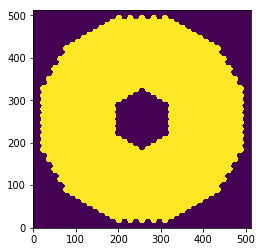

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files')))
npupil_L = update_config(**dict(read_config(), band='L'))['npupil']
npupil_N = update_config(**dict(read_config(), band='N2'))['npupil']
npupil = {'L':npupil_L, 'N2':npupil_N}
mask_L = fits.getdata('wavefront/cfull/mask_Cfull_20211007_%s_%s.fits'%('L', npupil_L)) > 0.5
mask_N = fits.getdata('wavefront/cfull/mask_Cfull_20211007_%s_%s.fits'%('N2', npupil_N)) > 0.5
mask = {'L':mask_L, 'N2':mask_N}
mask_M1 = fits.getdata('wavefront/ncpa/mask_M1_512.fits') > 0.5
filename = 'wavefront/ncpa/%s/DIFF_rep_%s_field_%s.fits'
tag = {'L':'LM_20211122', 'N2':'N_20211122'}
plt.imshow(mask_M1, origin='lower');

# Define functions

In [3]:
def get_median_field(band):
    nreps = 25
    nfields = 101
    rms_arr = np.empty((nreps, nfields))
    mu_rms_arr = []
    for i,rep in enumerate(range(1, nreps+1)):
        for j,field in enumerate(range(nfields)):
            ncpa = fits.getdata(filename%(tag[band], rep, field))*1e9
            rms_arr[i,j] = np.std(ncpa[mask_M1])
        print('rep=%s, RMS: %s = %.2f nm (%s = %.2f nm) '%
              (rep, chr(956), np.mean(rms_arr[i]), chr(963), np.std(rms_arr[i])))
        mu_rms_arr.append(np.mean(rms_arr[i]))
    reps = np.argsort(mu_rms_arr)[8:17] + 1
    print('selected reps: %s'%reps)
    med_rep = np.argsort(mu_rms_arr)[nreps//2] + 1
    print('median rep: %s'%med_rep)
    med_field = np.argsort(rms_arr[med_rep - 1])[nfields//2]
    print('median field: %s'%med_field)
    return reps, med_rep, med_field

def spatial_filter(band, rep, field):
    nimg = 512
    cpp = 10
    pupil_img_size = 39.9988
    diam_nominal = 38.542
    nkernel = nimg*diam_nominal/pupil_img_size
    kernel = conv_kernel(nkernel, cpp)
    ncpa = fits.getdata(filename%(tag[band], rep, field))*1e9
    allSF, LSF, HSF = spatial(ncpa*mask_M1, kernel, norm=True, verbose=True)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    plt.subplot(131); plt.title('all SF')
    im = plt.imshow(allSF*mask_M1, origin='lower')
    vmin, vmax = plt.gci().get_clim()
    plt.subplot(132); plt.title('LSF')
    plt.imshow(LSF*mask_M1, origin='lower', vmin=vmin, vmax=vmax)
    plt.subplot(133); plt.title('HSF')
    plt.imshow(HSF*mask_M1, origin='lower', vmin=vmin, vmax=vmax);

def create_staircase(band, reps, scao):
    for rep in reps:
        for i,field in enumerate(range(38, 62+1)):
            ncpa = fits.getdata(filename%(tag[band], rep, field))
            ncpa = resize_cube(ncpa, npupil[band])
            ncpa -= np.mean(ncpa[mask[band]]) # remove piston
            ncpa[~mask[band]] = 0             # mask with zeros
            stack = np.dstack([ncpa.T]*480).T
            if i == 0:
                cube = stack
            else:
                cube = np.vstack((cube, stack))
        cube += scao
        fits.writeto('wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_all_ncpa_%s_%s_rep_%s.fits'%
                     (band, npupil[band], rep), cube, overwrite=True)
        print('rep %s SCAO+NCPA: %.2f nm'%(rep, np.mean([np.std(x[mask[band]]) for x in cube*1e9])))

# Dynamic NCPA
### L band

rep=1, RMS: μ = 81.09 nm (σ = 2.74 nm) 
rep=2, RMS: μ = 106.68 nm (σ = 1.23 nm) 
rep=3, RMS: μ = 95.37 nm (σ = 2.55 nm) 
rep=4, RMS: μ = 97.76 nm (σ = 2.31 nm) 
rep=5, RMS: μ = 91.92 nm (σ = 0.72 nm) 
rep=6, RMS: μ = 97.75 nm (σ = 1.84 nm) 
rep=7, RMS: μ = 164.16 nm (σ = 1.21 nm) 
rep=8, RMS: μ = 71.55 nm (σ = 0.27 nm) 
rep=9, RMS: μ = 140.31 nm (σ = 5.32 nm) 
rep=10, RMS: μ = 105.94 nm (σ = 2.35 nm) 
rep=11, RMS: μ = 90.14 nm (σ = 0.68 nm) 
rep=12, RMS: μ = 76.34 nm (σ = 1.67 nm) 
rep=13, RMS: μ = 89.16 nm (σ = 2.18 nm) 
rep=14, RMS: μ = 119.46 nm (σ = 2.65 nm) 
rep=15, RMS: μ = 98.57 nm (σ = 1.24 nm) 
rep=16, RMS: μ = 85.27 nm (σ = 0.75 nm) 
rep=17, RMS: μ = 143.31 nm (σ = 8.04 nm) 
rep=18, RMS: μ = 111.05 nm (σ = 1.10 nm) 
rep=19, RMS: μ = 99.83 nm (σ = 2.75 nm) 
rep=20, RMS: μ = 133.30 nm (σ = 1.75 nm) 
rep=21, RMS: μ = 96.01 nm (σ = 1.30 nm) 
rep=22, RMS: μ = 114.84 nm (σ = 1.55 nm) 
rep=23, RMS: μ = 108.11 nm (σ = 2.60 nm) 
rep=24, RMS: μ = 98.36 nm (σ = 2.22 nm) 
rep=25, RMS: μ 

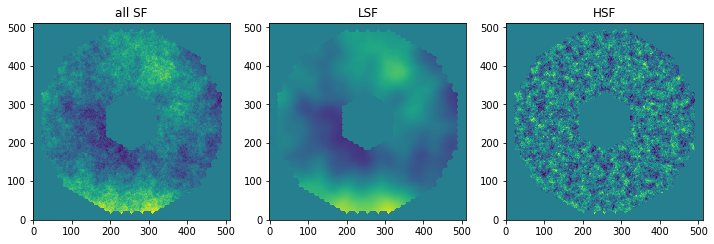

In [4]:
reps_L, med_rep_L, med_field_L = get_median_field('L')
spatial_filter('L', med_rep_L, med_field_L)

### L band: min = rep 8, max: rep 7

### N2 band

rep=1, RMS: μ = 95.76 nm (σ = 1.18 nm) 
rep=2, RMS: μ = 65.98 nm (σ = 1.08 nm) 
rep=3, RMS: μ = 138.88 nm (σ = 6.95 nm) 
rep=4, RMS: μ = 110.84 nm (σ = 5.89 nm) 
rep=5, RMS: μ = 87.75 nm (σ = 2.39 nm) 
rep=6, RMS: μ = 92.45 nm (σ = 1.28 nm) 
rep=7, RMS: μ = 150.03 nm (σ = 2.69 nm) 
rep=8, RMS: μ = 73.51 nm (σ = 1.11 nm) 
rep=9, RMS: μ = 93.50 nm (σ = 1.73 nm) 
rep=10, RMS: μ = 78.92 nm (σ = 5.10 nm) 
rep=11, RMS: μ = 101.97 nm (σ = 2.45 nm) 
rep=12, RMS: μ = 72.45 nm (σ = 0.72 nm) 
rep=13, RMS: μ = 97.23 nm (σ = 1.87 nm) 
rep=14, RMS: μ = 137.79 nm (σ = 2.49 nm) 
rep=15, RMS: μ = 98.19 nm (σ = 6.97 nm) 
rep=16, RMS: μ = 70.42 nm (σ = 0.60 nm) 
rep=17, RMS: μ = 83.43 nm (σ = 0.54 nm) 
rep=18, RMS: μ = 163.10 nm (σ = 4.46 nm) 
rep=19, RMS: μ = 110.81 nm (σ = 1.46 nm) 
rep=20, RMS: μ = 87.61 nm (σ = 5.52 nm) 
rep=21, RMS: μ = 167.10 nm (σ = 3.70 nm) 
rep=22, RMS: μ = 103.34 nm (σ = 2.53 nm) 
rep=23, RMS: μ = 109.52 nm (σ = 3.65 nm) 
rep=24, RMS: μ = 140.75 nm (σ = 4.58 nm) 
rep=25, RMS: μ

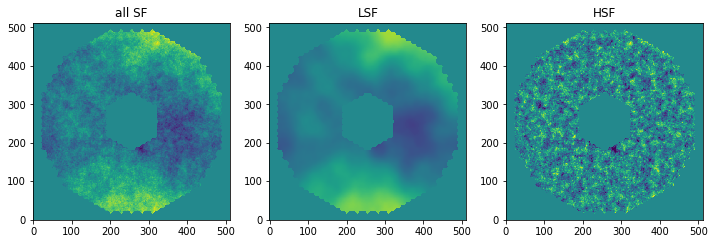

In [5]:
reps_N, med_rep_N, med_field_N = get_median_field('N2')
spatial_filter('N2', med_rep_N, med_field_N)

### N band: min = rep 2, max: rep 21

# SCAO + NCPA + petal piston: mean RMS

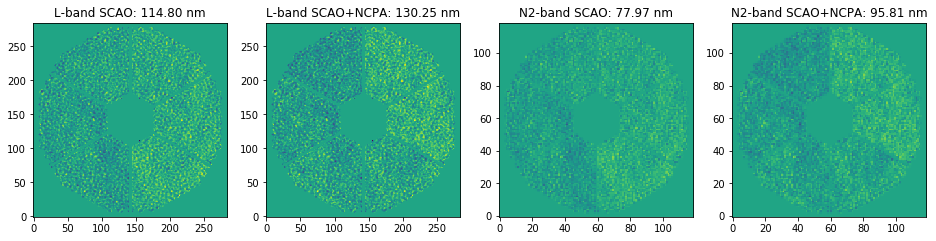

In [6]:
scao_L = fits.getdata('wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_%s_%s.fits'%('L', npupil_L))
ncpa_L = fits.getdata('wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_all_ncpa_%s_%s.fits'%('L', npupil_L))
scao_N = fits.getdata('wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_%s_%s.fits'%('N2', npupil_N))
ncpa_N = fits.getdata('wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_all_ncpa_%s_%s.fits'%('N2', npupil_N))
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
plt.subplot(141); plt.title('L-band SCAO: %.2f nm'%np.mean([np.std(x[mask_L]) for x in scao_L*1e9]))
im = plt.imshow(scao_L[0], origin='lower')
vmin, vmax = plt.gci().get_clim()
plt.subplot(142); plt.title('L-band SCAO+NCPA: %.2f nm'%np.mean([np.std(x[mask_L]) for x in ncpa_L*1e9]))
plt.imshow(ncpa_L[0], origin='lower', vmin=vmin, vmax=vmax)
plt.subplot(143); plt.title('N2-band SCAO: %.2f nm'%np.mean([np.std(x[mask_N]) for x in scao_N*1e9]))
plt.imshow(scao_N[0], origin='lower', vmin=vmin, vmax=vmax)
plt.subplot(144); plt.title('N2-band SCAO+NCPA: %.2f nm'%np.mean([np.std(x[mask_N]) for x in ncpa_N*1e9]))
plt.imshow(ncpa_N[0], origin='lower', vmin=vmin, vmax=vmax);

# 1-h staircase cubes

In [7]:
create_staircase('L', reps_L, scao_L)

rep 21 SCAO+NCPA: 149.86 nm
rep 6 SCAO+NCPA: 148.57 nm
rep 4 SCAO+NCPA: 151.78 nm
rep 24 SCAO+NCPA: 150.97 nm
rep 15 SCAO+NCPA: 151.06 nm
rep 19 SCAO+NCPA: 152.59 nm
rep 10 SCAO+NCPA: 153.66 nm
rep 2 SCAO+NCPA: 155.91 nm
rep 23 SCAO+NCPA: 154.16 nm


In [8]:
create_staircase('L', [8,7], scao_L)

rep 8 SCAO+NCPA: 134.04 nm
rep 7 SCAO+NCPA: 199.25 nm


In [9]:
create_staircase('N2', reps_N, scao_N)

rep 5 SCAO+NCPA: 111.87 nm
rep 6 SCAO+NCPA: 119.54 nm
rep 9 SCAO+NCPA: 120.13 nm
rep 1 SCAO+NCPA: 119.32 nm
rep 13 SCAO+NCPA: 123.13 nm
rep 15 SCAO+NCPA: 114.98 nm
rep 11 SCAO+NCPA: 127.09 nm
rep 22 SCAO+NCPA: 124.53 nm
rep 23 SCAO+NCPA: 134.89 nm


In [10]:
create_staircase('N2', [2,21], scao_N)

rep 2 SCAO+NCPA: 98.86 nm
rep 21 SCAO+NCPA: 184.30 nm
